# Building a Chatbot using LangGraph

In [80]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain.messages import HumanMessage, AIMessage, SystemMessage
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
load_dotenv()

True

In [81]:
# This module is to create a struct of message to pass between graph nodes
from langgraph.graph.message import BaseMessage, add_messages

class ChatState(TypedDict):
    message: Annotated[list[BaseMessage], add_messages]

In [82]:
x = ChatState(message ="hello", count = 1)
x

{'message': 'hello', 'count': 1}

In [83]:
print(type(x))
print(x["message"])

<class 'dict'>
hello


In [84]:
model = init_chat_model('gpt-5-nano')
model

ChatOpenAI(profile={'max_input_tokens': 272000, 'max_output_tokens': 128000, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x7f639ed6acc0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7f639ebfc080>, root_client=<openai.OpenAI object at 0x7f639f0d1e50>, root_async_client=<openai.AsyncOpenAI object at 0x7f639e52f200>, model_name='gpt-5-nano', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [85]:
def chat_node(state: ChatState):

    # Take user query from state
    message = state['message']

    # Send to model
    response = model.invoke(message)

    # Response Store State
    return { "message" : [response] }

In [86]:
# Making a Graph
graph = StateGraph(ChatState)

# Addding Nodes
graph.add_node('chat_node', chat_node)

# Adding Edges
graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

# Compile graph
chatbot = graph.compile()

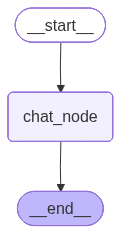

In [87]:
chatbot

In [88]:
initial_state = {
    'message': "Hi, How are you?"
}

final_state = chatbot.invoke(initial_state)

In [89]:
final_state['message'][1]

AIMessage(content="Hi there! I'm doing well, thanks for asking. How can I help you today? If you’d like, I can help with answers, writing, planning, coding, or just chat.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 240, 'prompt_tokens': 12, 'total_tokens': 252, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CzSgWcberGpfKlgu4SsPkWVZC9Tcg', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bd291-7c08-76d0-a5cd-6a1d68ff42cc-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 12, 'output_tokens': 240, 'total_tokens': 252, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'rea

In [ ]:
# Here in each loop a fresh invocation is happening
# it is not storing the state for next invocation
while True:

    user_message = input("Type Here:")

    print('User:', user_message)

    if user_message.strip().lower() in ['exit', 'bye', 'quit']:
        break

    response = chatbot.invoke({'message' : [HumanMessage(content=user_message)]})

    print('AI:', response['message'][-1].content)

Type Here: What is 36+14?


User: What is 36+14?
AI: 50


Type Here: add 16 to it


User: add 16 to it
AI: Could you tell me what “it” refers to? I need the current value to add 16 to it.

If you just want examples:
- 5 + 16 = 21
- 100 + 16 = 116

If you meant adding 16 days to a date, share the date and I’ll compute that too.


Type Here: exit


User: exit


# Storing the state of chat

In [102]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain.messages import HumanMessage, AIMessage, SystemMessage
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
load_dotenv()

True

In [103]:
# Memory Saver Acting as a Check Pointer
from langgraph.checkpoint.memory import MemorySaver

In [110]:
from langgraph.graph.message import add_messages


class ChatState(TypedDict):

    message : Annotated[list[BaseMessage], add_messages]

In [111]:
model = init_chat_model('gpt-5-nano')

In [112]:
def chat_node(state: ChatState):

    # Take user query from state
    message = state['message']

    # Send to model
    response = model.invoke(message)

    # Response Store State
    return { "message" : [response] }

In [113]:
# Creating an instance of Memory Saver
checkpointer = MemorySaver()

# Creating Graph
chat_graph = StateGraph(ChatState)

# Adding Node
chat_graph.add_node("chat_node", chat_node)

# Adding Edge
chat_graph.add_edge(START, "chat_node")
chat_graph.add_edge("chat_node", END)

# Compiling the Graph
chatbot = chat_graph.compile(checkpointer = checkpointer)

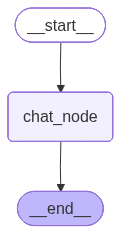

In [114]:
chatbot

In [115]:
# Here in each loop a fresh invocation is happening
# it is not storing the state for next invocation


# Thread if for the chat 
thread_id = '1'
while True:

    user_message = input("Type Here:")

    print('User:', user_message)

    if user_message.strip().lower() in ['exit', 'bye', 'quit']:
        break

    config = { "configurable" : { "thread_id" : thread_id }}
    response = chatbot.invoke({'message' : [HumanMessage(content=user_message)]}, config = config)

    print('AI:', response['message'][-1].content)

Type Here: 2+21?


User: 2+21?
AI: 23


Type Here: add 32 to this


User: add 32 to this
AI: 55


Type Here: cool, seems like you remeber previous exchange of messages?


User: cool, seems like you remeber previous exchange of messages?
AI: In this chat I can see and use our earlier messages, so I can refer back to them and stay in context (like the 23 and 55 results). I don’t have memory between separate conversations unless the platform stores it. If you want me to remember something for this session, just tell me and I’ll use it while we chat.


Type Here: exit


User: exit


In [116]:
chatbot.get_state(config = config)

StateSnapshot(values={'message': [HumanMessage(content='2+21?', additional_kwargs={}, response_metadata={}, id='d20b8d53-3995-4f6b-a9b8-4978576e201f'), AIMessage(content='23', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 10, 'total_tokens': 84, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CzT078dggcb25WLN339IF6XMzSmtK', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bd2a4-040b-72f2-869f-7f874b98ce36-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 10, 'output_tokens': 74, 'total_tokens': 84, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reaso